The objective of this notebook is to train and evaluate multiple machine learning models for customer churn prediction, compare their performance using appropriate metrics, and identify the most effective model for deployment.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("telco_model_ready.csv")
df.shape


(7032, 20)

Separate Features & Target

In [3]:
X = df.drop(columns=["Churn"])
y = df["Churn"]


Train–Test Split (Stratified)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


<h3>BASELINE MODEL: LOGISTIC REGRESSION</h3>

Logistic Regression Pipeline

In [5]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

In [6]:
X.dtypes

SeniorCitizen                       int64
tenure                              int64
MonthlyCharges                    float64
TotalCharges                      float64
high_monthly_charge                 int64
contract_length                     int64
auto_payment                        int64
has_support_services                int64
fiber_optic                         int64
gender_Male                          bool
Partner_Yes                          bool
Dependents_Yes                       bool
PhoneService_Yes                     bool
MultipleLines_No phone service       bool
MultipleLines_Yes                    bool
PaperlessBilling_Yes                 bool
tenure_group_1-2yr                   bool
tenure_group_2-4yr                   bool
tenure_group_4-6yr                   bool
dtype: object

In [7]:
log_reg.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

In [8]:
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC AUC: 0.833162068840561


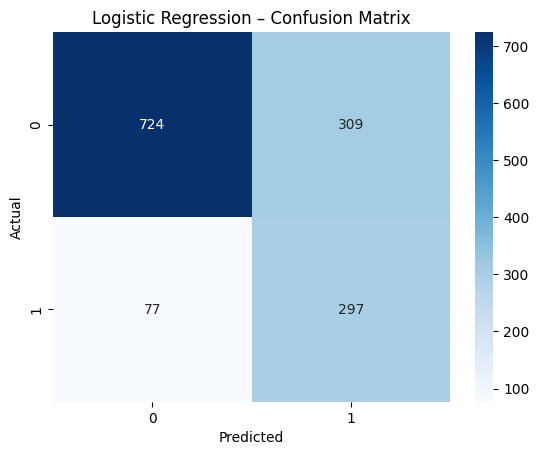

In [9]:
cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    class_weight="balanced"
)


In [11]:
rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [12]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

ROC AUC: 0.8092428470111973


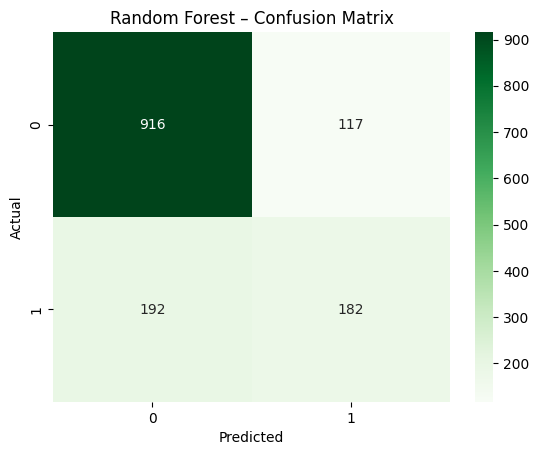

In [13]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


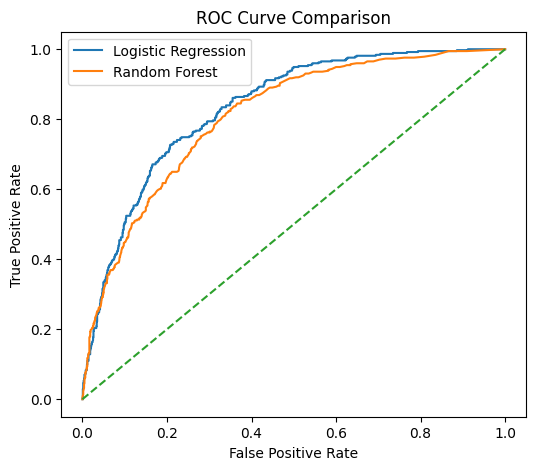

In [14]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,5))    
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


Although Random Forest captures non-linear interactions, Logistic Regression achieved a slightly higher ROC-AUC and performed better in the low false-positive region. Given its interpretability and competitive performance, Logistic Regression was selected as the final model.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs",
        random_state=42
    ))
])

param_grid = {
    "model__C": [0.01, 0.1, 1.0, 5.0, 10.0]
}

grid = GridSearchCV(
    log_reg,
    param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_


{'model__C': 10.0}

In [16]:
best_log_reg = grid.best_estimator_

y_prob_lr = best_log_reg.predict_proba(X_test)[:, 1]
y_pred_lr = best_log_reg.predict(X_test)

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC AUC: 0.8330844174332586


Logistic Regression was tuned using cross-validation by adjusting the regularization strength (C). A limited grid was used to balance performance and generalization. The tuned model showed marginal improvement in ROC-AUC, validating the robustness of the baseline model.

In churn prediction, the cost of missing a churned customer (false negative) is typically higher than incorrectly flagging a loyal customer. Therefore, optimizing the classification threshold to improve recall is often more valuable than maximizing overall accuracy.

<h3> Using default threshold </h3>

In [17]:

y_prob = best_log_reg.predict_proba(X_test)[:, 1]


<h3> Testing Multiple Thresholds </h3>

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.20, 0.61, 0.05)

rows = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    rows.append({
        "threshold": round(t, 2),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    })

threshold_df = pd.DataFrame(rows)
threshold_df



,threshold,precision,recall,f1
0,0.20,0.389371,0.959893,0.554012
1,0.25,0.408304,0.946524,0.570508
2,0.30,0.415459,0.919786,0.572379
3,0.35,0.430591,0.895722,0.581597
4,0.40,0.449861,0.863636,0.591575
5,0.45,0.470677,0.836898,0.602502
6,0.50,0.490099,0.794118,0.606122
7,0.55,0.513514,0.762032,0.613563
8,0.60,0.552209,0.735294,0.630734


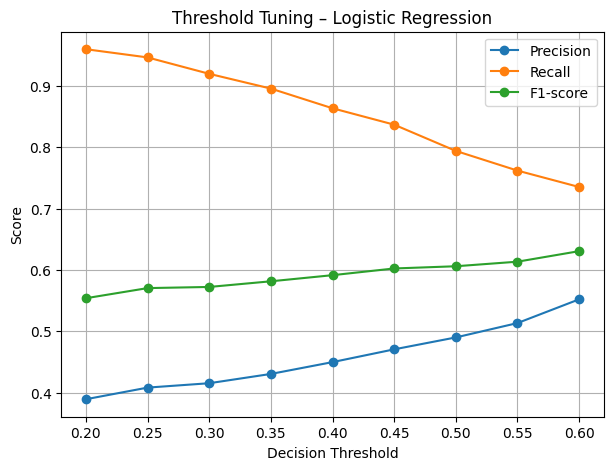

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(threshold_df["threshold"], threshold_df["precision"], marker="o", label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["recall"], marker="o", label="Recall")
plt.plot(threshold_df["threshold"], threshold_df["f1"], marker="o", label="F1-score")

plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()



In [20]:
BEST_THRESHOLD = 0.40


Recall ≈ 86% (strong churn capture)

Precision ≈ 45% (manageable false positives)

Reasonable F1

Avoids excessive customer targeting

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_final = (y_prob >= BEST_THRESHOLD).astype(int)

print(f"Final Threshold = {BEST_THRESHOLD}")
print(classification_report(y_test, y_pred_final))


Final Threshold = 0.4
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      1033
           1       0.45      0.86      0.59       374

    accuracy                           0.68      1407
   macro avg       0.69      0.74      0.67      1407
weighted avg       0.80      0.68      0.70      1407



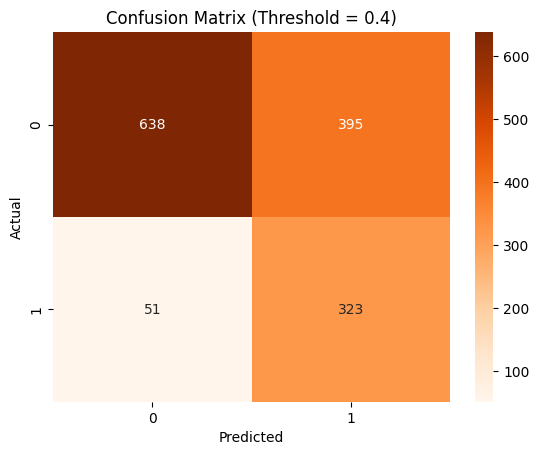

In [22]:
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title(f"Confusion Matrix (Threshold = {BEST_THRESHOLD})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Several decision thresholds were evaluated to balance precision and recall. A threshold of 0.40 was selected as it achieves a strong recall of approximately 86%, significantly reducing missed churn cases while maintaining a manageable precision level. This tradeoff aligns with churn prevention objectives, where proactively targeting at-risk customers is preferred over missing potential churners.